
# metrics.py API & Algorithm Documentation

This notebook documents the API and the theory behind the core metrics.

## Setup

In [1]:
#!pip install --user evo --upgrade --no-binary evo

In [2]:
from evo.core import metrics

**...some additional modules and settings for this demo:**

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os

In [5]:
from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

[DEBUG][2020-02-27 06:49:22,857][log.configure_logging():115]
System info:
Python 2.7.13
Linux-4.15.0-88-generic-x86_64-with-debian-9.3
user@793ef2caf567



/home/user/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


**Load two example trajectory files in TUM format;**

In [113]:
from evo.tools import file_interface

#ref_file = "../test/data/freiburg1_xyz-groundtruth.txt"
#est_file = "../test/data/freiburg1_xyz-rgbdslam_drift.txt"

#ref_file = "../test/data/fr2_desk_groundtruth.txt"
#est_file = "../test/data/fr2_desk_ORB_kf_mono.txt"

#ref_file = "../../wheel-odom/data/processed/gt/2019-05-22-13-29-41_nng/OXTSTrajectory.txt"
#ref_file = "../../wheel-odom/data/processed/orb_slam2_output/2019-05-22-10-59-06_nng/OXTSTrajectory.txt"
#est_file = "../../wheel-odom/data/processed/tmp/2019-05-22-10-59-06_nng/EncoderTrajectory.txt"
#est_file = "../../wheel-odom/data/processed/kf/2019-05-22-10-59-06_nng/KeyFrameTrajectory.txt"

bag_test = "2019-05-15-14-47-48_hmm"
# bag_test = "2019-05-22-13-59-06_nng"
# bag_test = "2019-05-22-13-28-08_nng"
# bag_test = "2019-05-22-11-38-25_nng"
# bag_test = "2019-05-22-11-13-41_nng"
# bag_test = "2019-05-13-14-27-05_hmm"
# bag_test = "2019-05-13-14-10-21_hmm"

cwd = os.getcwd()
git_dir = cwd[:cwd.find('git')+11]
data_dir = os.path.join(git_dir, "wheel-odom/data/processed/")
ref_file = os.path.join(data_dir,"orb_slam2_output",bag_test,"OXTSTrajectory.txt")
est_file_orb = os.path.join(data_dir, "kf", bag_test, "KeyFrameTrajectory.txt")
est_file_wo = os.path.join(data_dir, "tmp", bag_test, "EncoderTrajectory.txt")

traj_ref = file_interface.read_tum_trajectory_file(ref_file)
traj_est_orb = file_interface.read_tum_trajectory_file(est_file_orb)
traj_est_wo = file_interface.read_tum_trajectory_file(est_file_wo)

[DEBUG][2020-02-27 08:20:37,356][file_interface.read_tum_trajectory_file():112]
Loaded 2100 stamps and poses from: /home/mark_one/git_clones/wheel-odom/data/processed/orb_slam2_output/2019-05-15-14-47-48_hmm/OXTSTrajectory.txt
[DEBUG][2020-02-27 08:20:37,359][file_interface.read_tum_trajectory_file():112]
Loaded 123 stamps and poses from: /home/mark_one/git_clones/wheel-odom/data/processed/kf/2019-05-15-14-47-48_hmm/KeyFrameTrajectory.txt
[DEBUG][2020-02-27 08:20:37,362][file_interface.read_tum_trajectory_file():112]
Loaded 73 stamps and poses from: /home/mark_one/git_clones/wheel-odom/data/processed/tmp/2019-05-15-14-47-48_hmm/EncoderTrajectory.txt


 **The metrics require the trajectories to be associated via matching timestamps:**

In [114]:
from evo.core import sync

max_diff = 0.01

traj_ref_orb, traj_est_orb = sync.associate_trajectories(traj_ref, traj_est_orb, max_diff)
traj_ref_wo, traj_est_wo = sync.associate_trajectories(traj_ref, traj_est_wo, max_diff)

[DEBUG][2020-02-27 08:20:40,245][sync.associate_trajectories():106]
Found 123 of max. 2100 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).
[DEBUG][2020-02-27 08:20:40,249][sync.associate_trajectories():106]
Found 71 of max. 2100 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).


**Optionally, trajectory points can be aligned. Since we know the data associations, the alignment can be calculated in closed form using Umeyama's method [Umeyama-1991]. Additionally / alternatively, the scale can be corrected (e.g. for monocular SLAM).**

In [115]:
from evo.core import trajectory

traj_est_orb_aligned = trajectory.align_trajectory(traj_est_orb, traj_ref_orb, correct_scale=True, correct_only_scale=False)
traj_est_wo_aligned = trajectory.align_trajectory(traj_est_wo, traj_ref_wo, correct_scale=True, correct_only_scale=False)

[DEBUG][2020-02-27 08:20:41,037][trajectory.align_trajectory():401]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2020-02-27 08:20:41,040][trajectory.align_trajectory():411]
Rotation of alignment:
[[ 0.95579863 -0.00115711  0.2940198 ]
 [-0.29401457  0.00338126  0.95579496]
 [-0.00210012 -0.99999361  0.0028916 ]]
Translation of alignment:
[ 7.09239945e+01 -2.74121130e+02  1.24490429e-01]
[DEBUG][2020-02-27 08:20:41,043][trajectory.align_trajectory():412]
Scale correction: 10.8368577749
[DEBUG][2020-02-27 08:20:41,052][trajectory.align_trajectory():401]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2020-02-27 08:20:41,055][trajectory.align_trajectory():411]
Rotation of alignment:
[[ 1.28304722e-02 -9.99917686e-01 -1.03268808e-05]
 [-9.99917686e-01 -1.28304722e-02  2.20169176e-06]
 [-2.33400929e-06  1.02977820e-05 -1.00000000e+00]]
Translation of alignment:
[ 7.26905017e+01 -2.70681247e+02  5.16812843e-06]
[DEBUG][2020-02-27 08:20:41,058][traject

**Plot the trajectories:**

<IPython.core.display.Javascript object>


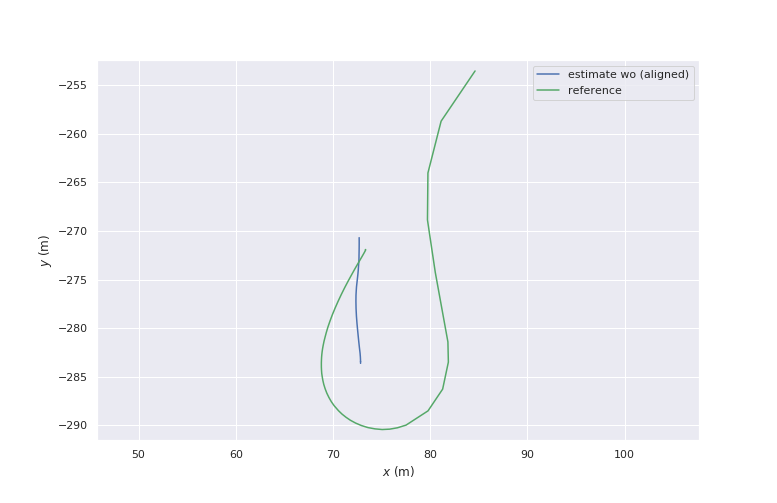

In [116]:
fig = plt.figure()
# traj_by_label = {
#     "estimate (not aligned)": traj_est,
#     "estimate (aligned)": traj_est_aligned,
#     "reference": traj_ref
# }
traj_by_label = {
    "estimate ORB (aligned)": traj_est_orb_aligned,
    "estimate Odom (aligned)": traj_est_wo_aligned,
    "reference": traj_ref_orb
}
traj_by_label = {
    "estimate ORB (aligned)": traj_est_orb_aligned,
    "reference": traj_ref_orb
}
# traj_by_label = {
#     "estimate wo": traj_est_wo
# }
traj_by_label = {
    "estimate wo (aligned)": traj_est_wo_aligned,
    "reference": traj_ref_wo
}

plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()

<a id='ape_math'></a>
## APE
***The absolute pose error is a metric for investigating the global consistency of a SLAM trajectory***

APE is based on the absolute relative pose between two poses $P_{ref,i}, P_{est,i} \in \mathrm{SE}(3)$ at timestamp $i$:
\begin{equation*}
E_i = P_{est,i} \ominus P_{ref,i} = P_{ref,i}^{-1} P_{est,i} \in \mathrm{SE}(3)
\end{equation*}
where $\ominus$ is the inverse compositional operator, which takes two poses and gives the relative pose [Lu-1997].
You can use different pose relations to calculate the APE:
* **`metrics.PoseRelation.translation_part`**
    * this uses the translation part of $E_i$
    * $ APE_i = \| \mathrm{trans}(E_i) \| $
* **`metrics.PoseRelation.rotation_angle_(rad/deg)`**
    * uses the rotation angle of $E_i$
    * $ APE_i = |( \mathrm{angle}(\log_{\mathrm{SO}(3)}(\mathrm{rot}(E_i)) )| $
    * $ \log_{\mathrm{SO}(3)}(\cdot) $ is the inverse of $ \exp_{\mathfrak{so}(3)}(\cdot) $ (Rodrigues' formula)
* **`metrics.PoseRelation.rotation_part`**
    * this uses the rotation part of $E_i$
    * $ APE_i = \| \mathrm{rot}(E_i) - I_{3 \times 3} \|_F $
    * unit-less
* **`metrics.PoseRelation.full_transformation`**
    * this uses the full relative pose $E_i$
    * $ APE_i = \| E_i - I_{4 \times 4} \|_F $
    * unit-less
    
Then, different statistics can be calculated on the APEs of all timestamps, e.g. the RMSE:
\begin{equation*}
\mathrm{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^N APE_i^2 } 
\end{equation*}

### Settings

In [8]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = False

### Data Preparation
Optionally, we can use the aligned trajectory:

In [9]:
if use_aligned_trajectories:
    data = (traj_ref, traj_est_aligned) 
else:
    data = (traj_ref, traj_est)

### Run APE on Data
Create an instance of the APE class and process the data

In [10]:
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

[DEBUG][2020-02-19 05:14:12,874][metrics.process_data():374]
Compared 785 absolute pose pairs.
[DEBUG][2020-02-19 05:14:12,876][metrics.process_data():376]
Calculating APE for rotation angle in degrees pose relation...


### Get APE Statistics
Get a single statistic:

In [11]:
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)

36.1778970516


Get all avalaible statistics at once in a dictionary:

In [12]:
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

{'max': 37.23436902081525,
 'mean': 36.17603563973775,
 'median': 36.16726866944314,
 'min': 34.82015315838179,
 'rmse': 36.17789705156791,
 'sse': 1027439.5845329692,
 'std': 0.3669883734809711}


Plot the APE values and statistics:

<IPython.core.display.Javascript object>


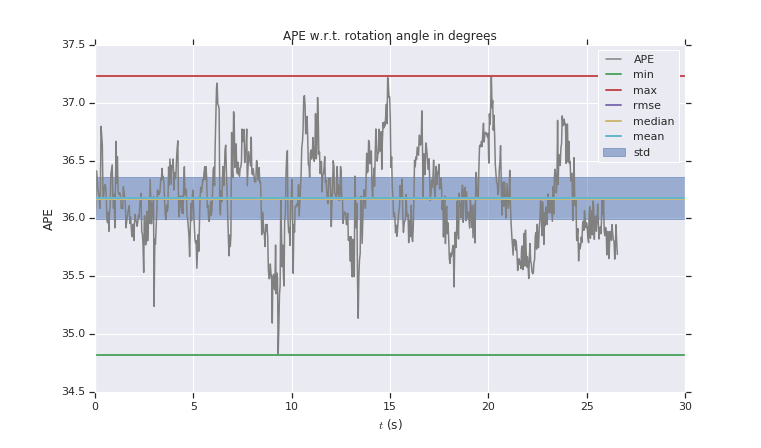

In [13]:
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()
plot.error_array(fig, ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

Plot the trajectory with colormapping of the APE:

<IPython.core.display.Javascript object>


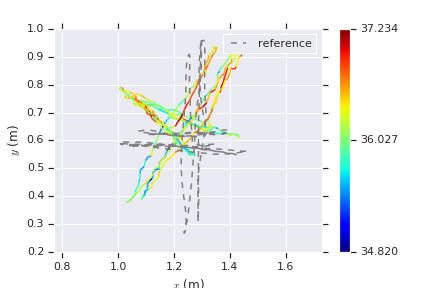

In [14]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

### Comparison with TUM ATE script

The official TUM RGB-D benchmark script `evaluate_ate.py` [Sturm-2012] gives the RMSE of the xyz difference of the aligned trajectories:

In [14]:
import subprocess as sp
import sys
cmd = ["python2", "../test/tum_benchmark_tools/evaluate_ate.py", ref_file, est_file, "--max_difference", str(max_diff)]
out = sp.check_output(cmd)
print(out.decode(sys.stdout.encoding))

0.013470



...which is equivalent to:

In [15]:
tum_ate_equivalent = metrics.APE(metrics.PoseRelation.translation_part)
tum_ate_equivalent.process_data((traj_ref, traj_est_aligned))
print(tum_ate_equivalent.get_statistic(metrics.StatisticsType.rmse))

[DEBUG][2020-02-18 21:25:07,793][metrics.process_data():374]
Compared 785 absolute pose pairs.
[DEBUG][2020-02-18 21:25:07,796][metrics.process_data():376]
Calculating APE for translation part pose relation...
0.0134701189514


<a id='rpe_math'></a>
# RPE

***The relative pose error is a metric for investigating the local consistency of a SLAM trajectory***

RPE compares the relative poses along the estimated and the reference trajectory. This is based on the delta pose difference: 
\begin{equation*} E_{i,j} = \delta_{est_{i,j}} \ominus \delta_{ref_{i,j}} = (P_{ref,i}^{-1}P_{ref,j})^{-1} (P_{est,i}^{-1}P_{est,j}) \in \mathrm{SE}(3) \end{equation*}

You can use different pose relations to calculate the RPE from timestamp $i$ to $j$:
* **`metrics.PoseRelation.translation_part`**
    * this uses the translation part of $E_{i,j}$
    * $ RPE_{i,j} = \| \mathrm{trans}(E_{i,j}) \| $
* **`metrics.PoseRelation.rotation_angle_(rad/deg)`**
    * uses the absolute angular error of $E_{i,j}$
    * $ RPE_{i,j} = |( \mathrm{angle}(\log_{\mathrm{SO}(3)}(\mathrm{rot}(E_{i,j})) )| $
    * $ \log_{\mathrm{SO}(3)}(\cdot) $ is the inverse of $ \exp_{\mathfrak{so}(3)}(\cdot) $ (Rodrigues' formula)
* **`metrics.PoseRelation.rotation_part`**
    * this uses the rotation part of $E_{i,j}$
    * $ RPE_{i,j} = \| \mathrm{rot}(E_{i,j}) - I_{3 \times 3} \|_F $
    * unit-less
* **`metrics.PoseRelation.full_transformation`**
    * this uses the full delta pose difference $E_{i,j}$
    * $ RPE_{i,j} = \| E_{i,j} - I_{4 \times 4} \|_F $
    * unit-less
    
Then, different statistics can be calculated on the RPEs of all timestamps, e.g. the RMSE:
\begin{equation*}
\mathrm{RMSE} = \sqrt{ \frac{1}{N} \sum_{\forall ~i,j} RPE_{i,j}^2 } 
\end{equation*}

### Settings

The parameter $\Delta$ determines the distance between the pose pairs along the trajectories. E.g. if you have 30 poses per second and want to measure the RPE every second, use $\Delta=30 ~\text{(frames)}$. Or to measure everytime you moved 1 meter, $\Delta=1 ~\text{(m)}$, ...

Another option is to use all pairs of a certain delta value, i.e. not only the subsequent (linear) delta pairs of the trajectory.

Using aligned trajectories does not make sense with RPE because the delta poses are the same as with the unaligned case.

In [58]:
# pose_relation = metrics.PoseRelation.rotation_angle_deg
pose_relation = metrics.PoseRelation.translation_part

# normal mode
delta = 1
delta_unit = metrics.Unit.frames

# all pairs mode
all_pairs = False  # activate

### Data Preparation ORB

In [80]:
# data = (traj_ref, traj_est)
data = (traj_ref_orb, traj_est_orb)

### Run RPE on Data
Create an instance of the RPE class and process the data

In [81]:
rpe_metric = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric.process_data(data)

[DEBUG][2020-02-27 07:05:13,244][filters.id_pairs_from_delta():174]
Found 122 pairs with delta 1 (frames) among 123 poses using consecutive pairs.
[DEBUG][2020-02-27 07:05:13,256][metrics.process_data():279]
Compared 122 relative pose pairs, delta = 1 (frames) with consecutive pairs.
[DEBUG][2020-02-27 07:05:13,258][metrics.process_data():282]
Calculating RPE for translation part pose relation...


### Get RPE Statistics
Get a single statistic:

In [82]:
rpe_stat = rpe_metric.get_statistic(metrics.StatisticsType.rmse)
print(rpe_stat)

0.80959184703


Get all avalaible statistics at once in a dictionary:

In [83]:
rpe_stats = rpe_metric.get_all_statistics()
pprint.pprint(rpe_stats)

{'max': 3.440652282134871,
 'mean': 0.6355349105597062,
 'median': 0.49282006924746025,
 'min': 0.050104192570817455,
 'rmse': 0.8095918470304418,
 'sse': 79.96355297093581,
 'std': 0.5015319892469755}


**Plot the RPE values and statistics for ORBSLAM2:**

In [84]:
# important: restrict data to delta ids for plot
import copy
# traj_ref_plot = copy.deepcopy(traj_ref)
# traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot = copy.deepcopy(traj_ref_orb)
traj_est_plot = copy.deepcopy(traj_est_orb)
traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]
seconds_from_start = [t - traj_est_orb.timestamps[0] for t in traj_est_orb.timestamps[1:]]

<IPython.core.display.Javascript object>


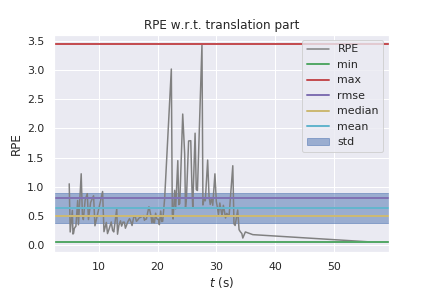

In [85]:
fig = plt.figure()
plot.error_array(fig, rpe_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in rpe_stats.items() if s != "sse"},
                 name="RPE", title="RPE w.r.t. " + rpe_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

Plot the trajectory with colormapping of the RPE:

<IPython.core.display.Javascript object>


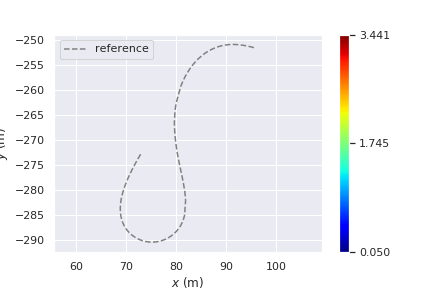

In [86]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_metric.error, plot_mode, min_map=rpe_stats["min"], max_map=rpe_stats["max"])
ax.legend()
plt.show()

### Data Preparation Wheel Odom

In [87]:
# data = (traj_ref, traj_est)
data = (traj_ref_wo, traj_est_wo)

### Run RPE on Data
Create an instance of the RPE class and process the data

In [88]:
rpe_metric = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric.process_data(data)

[DEBUG][2020-02-27 07:05:20,569][filters.id_pairs_from_delta():174]
Found 70 pairs with delta 1 (frames) among 71 poses using consecutive pairs.
[DEBUG][2020-02-27 07:05:20,573][metrics.process_data():279]
Compared 70 relative pose pairs, delta = 1 (frames) with consecutive pairs.
[DEBUG][2020-02-27 07:05:20,576][metrics.process_data():282]
Calculating RPE for translation part pose relation...


### Get RPE Statistics
Get a single statistic:

In [89]:
rpe_stat = rpe_metric.get_statistic(metrics.StatisticsType.rmse)
print(rpe_stat)

1.84449610417


Get all avalaible statistics at once in a dictionary:

In [90]:
rpe_stats = rpe_metric.get_all_statistics()
pprint.pprint(rpe_stats)

{'max': 7.270235934429723,
 'mean': 1.1277482388881672,
 'median': 0.5955231378476125,
 'min': 0.0024511376965644033,
 'rmse': 1.8444961041687329,
 'sse': 238.15161148055432,
 'std': 1.4595717823999852}


**Plot the RPE values and statistics for ORBSLAM2:**

In [91]:
# important: restrict data to delta ids for plot
import copy
# traj_ref_plot = copy.deepcopy(traj_ref)
# traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot = copy.deepcopy(traj_ref_wo)
traj_est_plot = copy.deepcopy(traj_est_wo)
traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]
seconds_from_start = [t - traj_est_wo.timestamps[0] for t in traj_est_wo.timestamps[1:]]

<IPython.core.display.Javascript object>


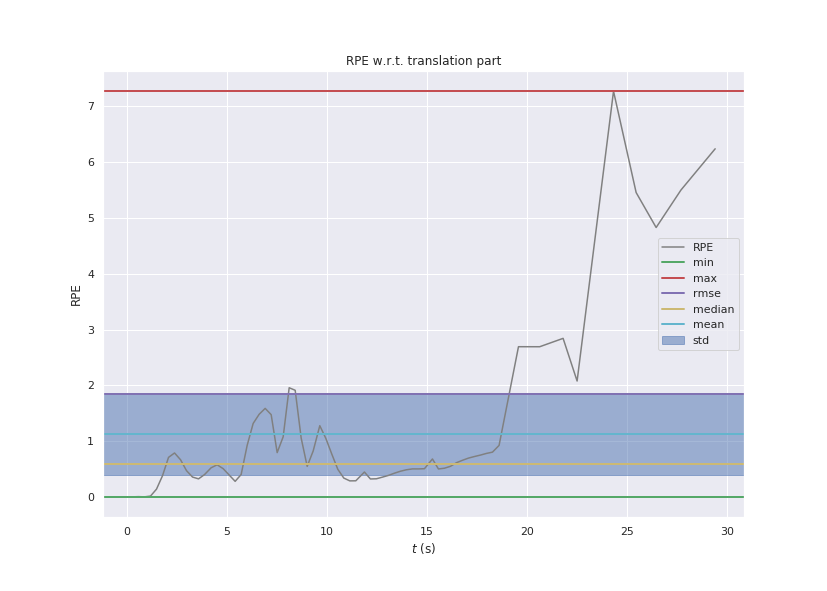

In [92]:
fig = plt.figure()
plot.error_array(fig, rpe_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in rpe_stats.items() if s != "sse"},
                 name="RPE", title="RPE w.r.t. " + rpe_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

Plot the trajectory with colormapping of the RPE:

<IPython.core.display.Javascript object>


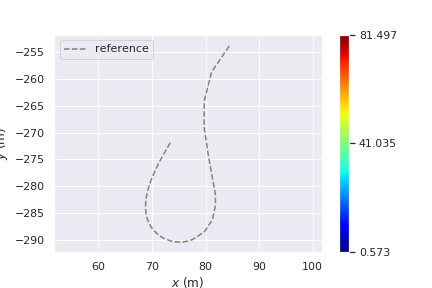

In [53]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_metric.error, plot_mode, min_map=rpe_stats["min"], max_map=rpe_stats["max"])
ax.legend()
plt.show()

### Comparison with TUM RPE script

The official TUM RGB-D benchmark script evaluate_rpe.py uses all pairs of the specified delta (in "fixed_delta" mode only!). 

The default output is the mean of the RPE:

In [35]:
import subprocess as sp
import sys
delta = 15
# cmd = cmd = ["python2", "../test/tum_benchmark_tools/evaluate_rpe.py", ref_file, est_file, "--delta", str(delta), "--delta_unit", 'f', '--fixed_delta']
cmd = cmd = ["python2", "../test/tum_benchmark_tools/evaluate_rpe.py", ref_file, est_file_orb, "--delta", str(delta), "--delta_unit", 'f', '--fixed_delta']
out = sp.check_output(cmd)
print(out.decode(sys.stdout.encoding))

7.303382309556894



...which is equivalent to:

In [37]:
tum_rpe_equivalent = metrics.RPE(metrics.PoseRelation.translation_part, delta, metrics.Unit.frames, all_pairs=True)
# tum_rpe_equivalent.process_data((traj_ref, traj_est))
tum_rpe_equivalent.process_data((traj_ref_orb, traj_est_orb))
print(tum_rpe_equivalent.get_statistic(metrics.StatisticsType.mean))

[DEBUG][2020-02-27 06:43:59,347][filters.id_pairs_from_delta():174]
Found 63 pairs with delta 15 (frames) among 78 poses using all pairs.
[DEBUG][2020-02-27 06:43:59,350][metrics.process_data():279]
Compared 63 relative pose pairs, delta = 15 (frames) with all pairs.
[DEBUG][2020-02-27 06:43:59,353][metrics.process_data():282]
Calculating RPE for translation part pose relation...
7.27458343120673


## References

|   |   |
|---|---|
| [Kümmerle-2009] | Rainer Kümmerle, Bastian Steder, Christian Dornhege, Michael Ruhnke, Giorgio Grisetti, Cyrill Stachniss, and Alexander Kleiner. On measuring the accuracy of SLAM algorithms. *Autonomous Robots*, 27(4):387–407, 2009.
| [Lu-1997] | Feng Lu and Evangelos Milios. Globally consistent range scan alignment for environment mapping. *Autonomous Robots*, 4(4):333–349, 1997.
| [Sturm-2012] | Jürgen Sturm, Nikolas Engelhard, Felix Endres, Wolfram Burgard, and Daniel Cremers. A benchmark for the evaluation of RGB-D SLAM systems. *In 2012 IEEE/RSJ International Conference on Intelligent Robots and Systems*, pages 573–580. IEEE, 2012.
| [Umeyama-1991] | Umeyama, Shinji. Least-squares estimation of transformation parameters between two point patterns. *IEEE Transactions on Pattern Analysis & Machine Intelligence* 4:376-380, 1991.